# Analysis of Money Supply in the Eurozone
Money supply in the Eurozone is not much different from that in the US and is made up of the following money aggregates:

Type of money | MB | M1 | M2 | M3
--- | --- | --- | --- | ---
Currency in circulation | ✓ | ✓ | ✓ | ✓
Reserve balances | ✓ |  |   |  
Overnight deposits (aka Demand deposits) |  | ✓ | ✓ | ✓ 
Deposits with an agreed maturity of up to 2 years or redeemable at notice of up to 3 months |  |  | ✓ | ✓
Repurchase agreements, Money market funds, Debt securities with maturity of up to 2 years |  |  |  | ✓

As you can see from the above table, `MB` currency in circulation < `M1` < `M2` < `M3` as each of the larger money supply aggregates includes the preceeding one. I use both nominal and real measures by deflating nominal measures with Eurozone's Harmonized Index of Consumer Prices (HICP).

I make use of the datasets provided by the ECB to carry out this analysis. In contrast to the Fed, which stopped publishing data on M3 in 2006, the ECB still does it.

Analogously with [the Money supply analysis for the US](./Money_Supply.ipynb) I use not seasonally adjusted datasets. Likewise, I derived real money supply in parts of this notebook by using consumer price index as the deflator.

In [1]:
# Uncomment if running in Google Colaboratory

# Install the latest version of pandaSDMX
# !pip install sdmx1 -U
# !pip install eurostat -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay

import eurostat
import sdmx

from datetime import date

from dateutil.relativedelta import relativedelta

In [3]:
report_start = date.fromisoformat('2008-10-01')
report_end = date.today()

### Preparing factors for conversion from nominal to real amounts by adjusing for monthly Harmonized Index of Consumer Prices (HICP &mdash; Eurozone's CPI)

In [4]:
# Using Eurozone price index 2015=100, and All-items HICP: CP00 
eu_hicp = eurostat.get_data_df('prc_hicp_midx',
               filter_pars={'startPeriod': report_start, 'unit': 'I15', 'coicop': 'CP00', 'geo': 'EA'}).iloc[:, 3:]
eu_hicp = eu_hicp.set_index(eu_hicp.columns[0]).T
eu_hicp = eu_hicp.set_axis(pd.DatetimeIndex(eu_hicp.index, 'MS'))

## Analysis of annual changes in the main components of M3

In [5]:
# M.U2.N.V.L10.X.1.U2.2300.Z01.E <-- Currency in circulation
# M.U2.N.V.M10.X.1.U2.2300.Z01.E <-- M1
# M.U2.N.V.M20.X.1.U2.2300.Z01.E <-- M2
# M.U2.N.V.M30.X.1.U2.2300.Z01.E <-- M3
# Retrieving them all in one go                               
ecb = sdmx.Client('ECB')  
data_msg = ecb.data('BSI', key='M.U2.N.V..X.1.U2.2300.Z01.E', params={'startPeriod': report_start, 
                                                                      'endPeriod': report_end})

In [6]:
df = sdmx.to_pandas(data_msg.data[0]).loc['M', 'U2', 'N', 'V', :, 'X', '1', 'U2', '2300', 'Z01', 'E'].unstack(-2)
df.columns.names = [None]

In [7]:
m1_addons = (df.loc[:, 'M10'] - df.loc[:, 'L10']).rename('M1 Add-ons')
m2_addons = (df.loc[:, 'M20'] - df.loc[:, 'M10']).rename('M2 Add-ons')
m3_addons = (df.loc[:, 'M30'] - df.loc[:, 'M20']).rename('M3 Add-ons')

In [8]:
m3_df = pd.concat([df.loc[:, ['M30', 'L10']], m1_addons, m2_addons, m3_addons], axis=1)
m3_df = m3_df.set_axis(pd.DatetimeIndex(m3_df.index, 'MS'))
m3_df.rename(columns={'L10': 'MB Currency in circulation', 'M30': 'M3 Total'}, inplace=True)

# Converting into billions of Euros
m3_df /= 1000.

In [9]:
m3_df

,M3 Total,MB Currency in circulation,M1 Add-ons,M2 Add-ons,M3 Add-ons
TIME_PERIOD,,,,,
2008-10-01,9326.351030,698.783573,3245.683158,4027.655269,1354.229030
2008-11-01,9367.448353,703.623942,3266.057343,4049.303799,1348.463269
2008-12-01,9423.780086,722.746037,3312.996312,4067.314628,1320.723109
2009-01-01,9400.007135,712.198952,3383.950818,4005.742439,1298.114926
2009-02-01,9414.394921,715.828862,3386.039071,3991.931310,1320.595678
...,...,...,...,...,...
2024-11-01,16740.250153,1546.006297,9047.485228,4972.850817,1173.907812
2024-12-01,16825.417176,1561.887404,9099.615386,4997.857462,1166.056923
2025-01-01,16748.088058,1549.379565,8973.571104,5002.905671,1222.231718


In [10]:
last_idx = min(eu_hicp.index[-1], m3_df.index[-1])
eu_hicp = eu_hicp.loc[:last_idx]
# Convert into pandas.Series
nom_2_real_conv_factors = (eu_hicp.iloc[-1] / eu_hicp).iloc[:,0].rename('Conversion factor')

# Convert from nominal into real money supply
m3real_df = m3_df.multiply(nom_2_real_conv_factors, axis=0).dropna()

m3real_df.rename(
    columns={m3_df.columns[0]: 'Real ' + m3_df.columns[0], m3_df.columns[1]: 'Real ' + m3_df.columns[1],
             m3_df.columns[2]: 'Real ' + m3_df.columns[2], m3_df.columns[3]: 'Real ' + m3_df.columns[3]},
    inplace=True)

In [11]:
m3real_df

,Real M3 Total,Real MB Currency in circulation,Real M1 Add-ons,Real M2 Add-ons,M3 Add-ons
TIME_PERIOD,,,,,
2008-10-01,12974.206713,972.101789,4515.181134,5603.009351,1883.914439
2008-11-01,13095.404379,983.644607,4565.847606,5660.802035,1885.110132
2008-12-01,13191.437654,1011.702226,4637.542886,5693.440089,1848.752453
2009-01-01,13268.403854,1005.291079,4776.552339,5654.230646,1832.329789
2009-02-01,13234.729092,1006.310139,4760.083912,5611.845465,1856.489576
...,...,...,...,...,...
2024-11-01,16927.986334,1563.344229,9148.949681,5028.619638,1187.072786
2024-12-01,16953.855475,1573.810209,9169.078099,5036.009046,1174.958121
2025-01-01,16922.547309,1565.518935,9067.045803,5055.019272,1234.963298


## Visualization of Eurozone's Nominal M3 Money Supply

In [12]:
M3_COMPOSITION_TITLE = 'Composition of Eurozone M3 Money Supply'
REALM3_COMPOSITION_TITLE = 'Composition of Eurozone Real M3 Money Supply'
IN_EURO_FORMATER = ' in {:%Y-%m} Euros'
LEFT_Y_AXIS_LABEL = 'Billions of Euros'

### Stacked Visualization Amounting to Total Eurozone M3 Money Supply

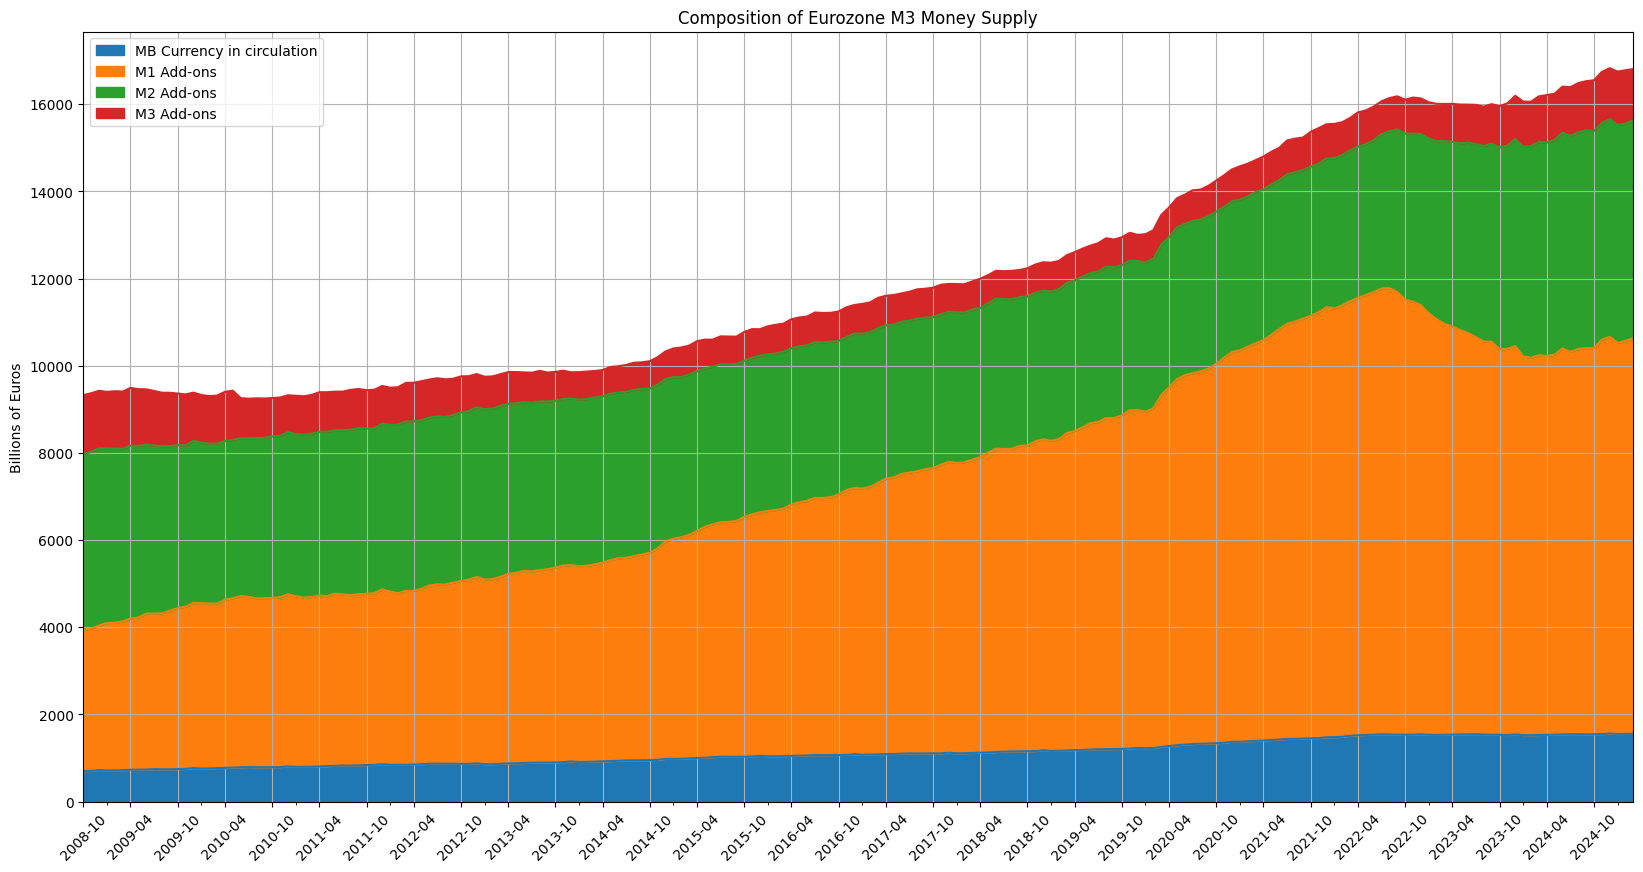

In [13]:
ax = m3_df.iloc[:,1:].plot.area(figsize=(20,10), grid=True, title=M3_COMPOSITION_TITLE,
                     xticks=m3_df.index[::6], xlabel='', rot=45,
                     ylabel=LEFT_Y_AXIS_LABEL)#, yticks=np.arange(0, 25e3, 2.5e3))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_df.index[::6])))

In [14]:
idxmax = m3_df.iloc[:,0].idxmax()
print('Nominal M3 money supply maximum of \u20ac{:>8.2f}bn reached in month {:%Y-%m}'
      .format(m3_df.loc[idxmax, m3_df.columns[0]], idxmax))
print('Nominal M3 money supply changed by  \u20ac{:>8.2f}bn since (as of month {:%Y-%m})'
      .format(m3_df.iloc[-1,0]-m3_df.loc[idxmax, m3_df.columns[0]], m3_df.index[-1]))
print('Nominal M3 money supply changed by  \u20ac{:>8.2f}bn since {:%Y-%m} to \u20ac{:.2f}bn'
      .format(m3_df.iloc[-1,0]-m3_df.iloc[-2,0], m3_df.index[-2], m3_df.iloc[-1,0]))

Nominal M3 money supply maximum of €16825.42bn reached in month 2024-12
Nominal M3 money supply changed by  €  -19.30bn since (as of month 2025-03)
Nominal M3 money supply changed by  €   27.31bn since 2025-02 to €16806.12bn


In [15]:
m3_df.iloc[-1,:] - m3_df.iloc[-2,:]

M3 Total                      27.313488
MB Currency in circulation     3.782165
M1 Add-ons                    57.010657
M2 Add-ons                    16.435392
M3 Add-ons                   -49.914726
dtype: float64

### Visualization as Percent of Total Eurozone M3 Money Supply

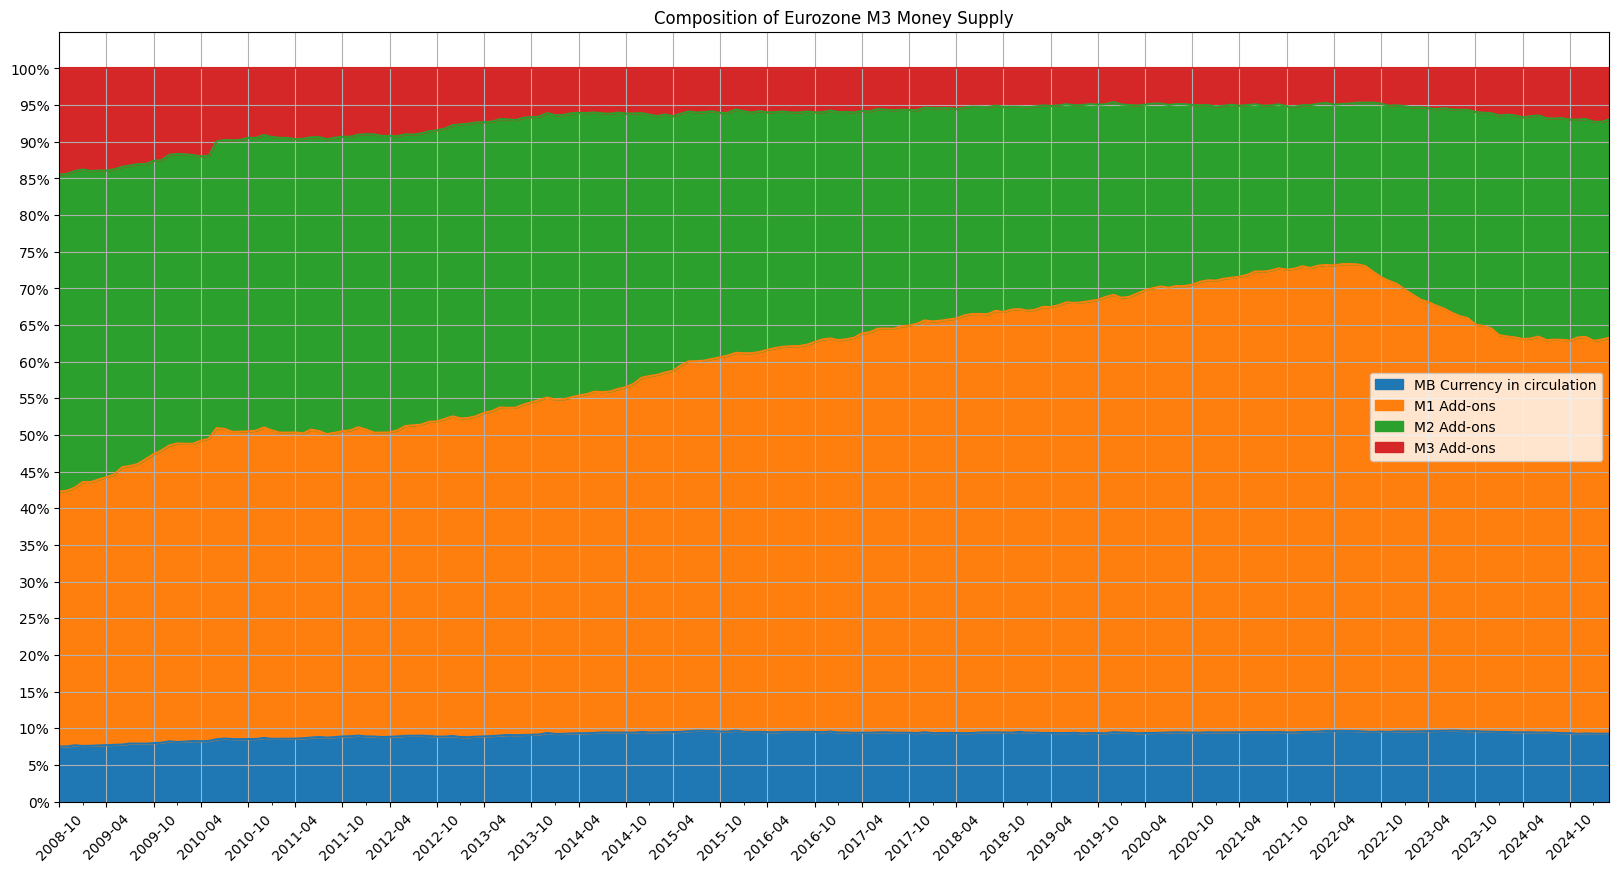

In [16]:
# Converting to percentages by dividing by total M3 Money Supply.
# Dividing by the total M3 Money Supply
m3_df_pct = m3_df.iloc[:,1:].divide(m3_df.iloc[:,0], axis=0)
m3_df_pct *= 100

ax = m3_df_pct.plot.area(figsize=(20,10), grid=True, title=M3_COMPOSITION_TITLE,
                         xticks=m3_df_pct.index[::6], xlabel='', rot=45,
                         yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_df_pct.index[::6])))

In [17]:
m3_df_pct.iloc[-1,:] - m3_df_pct.iloc[-2,:]

MB Currency in circulation    0.007483
M1 Add-ons                    0.251883
M2 Add-ons                    0.049519
M3 Add-ons                   -0.308885
dtype: float64

## Visualization of Eurozone's Real M3 Money Supply

### Stacked Visualization Amounting to Total Eurozone Real M3 Money Supply

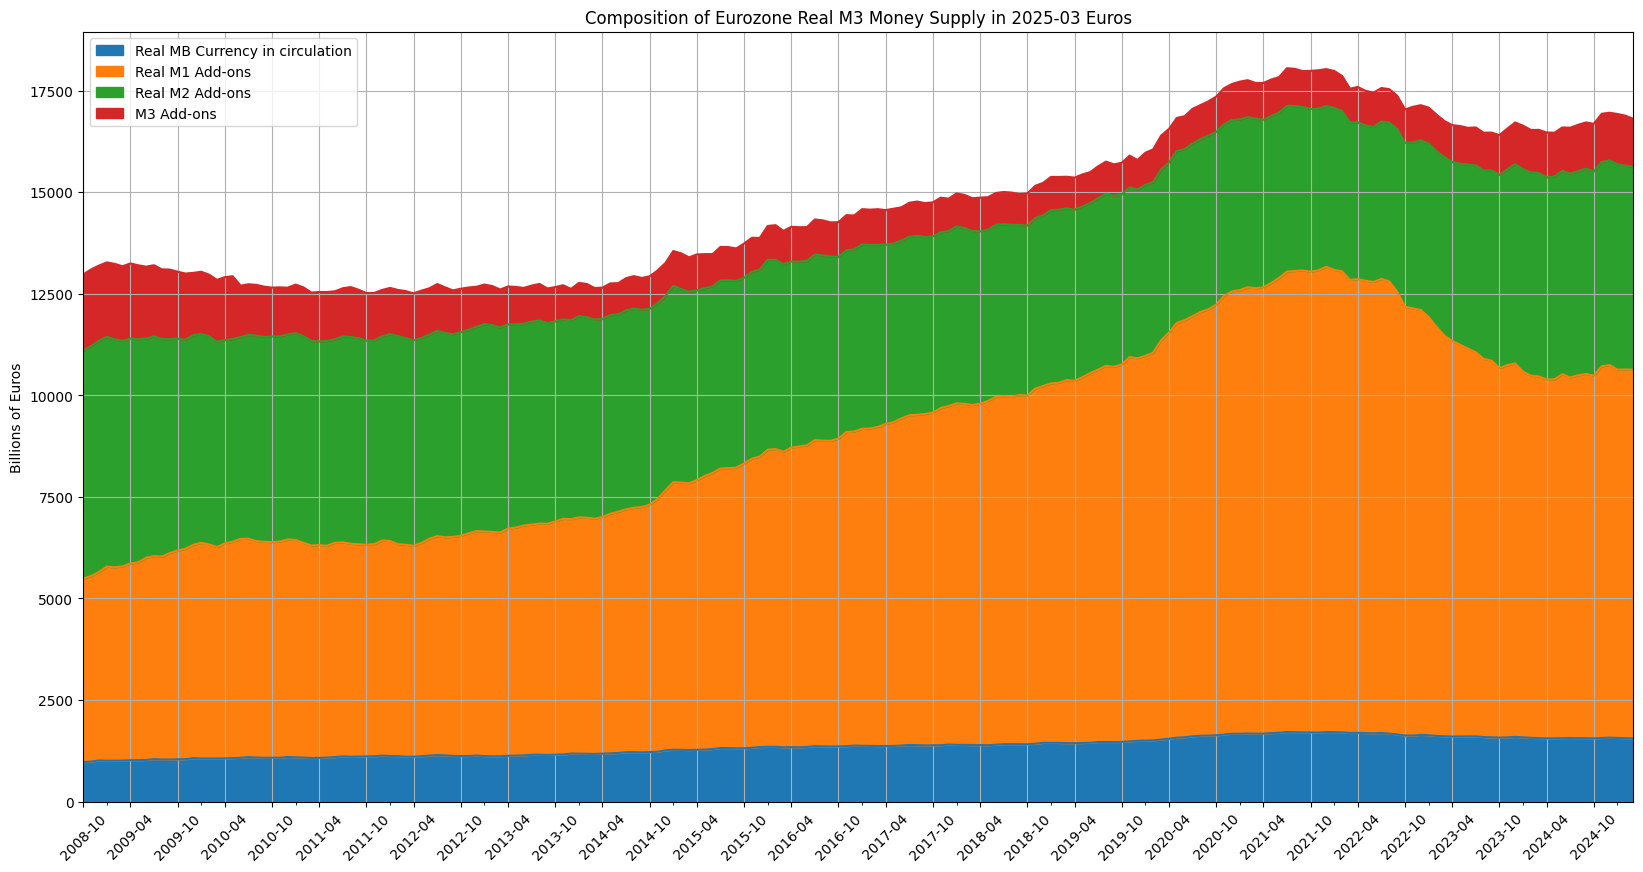

In [18]:
ax = m3real_df.iloc[:,1:].plot.area(
                figsize=(20,10), grid=True,
                title=REALM3_COMPOSITION_TITLE + IN_EURO_FORMATER.format(m3real_df.index[-1].date()),
                xticks=m3real_df.index[::6], xlabel='', rot=45,
                ylabel=LEFT_Y_AXIS_LABEL)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3real_df.index[::6])))

In [19]:
idxmax = m3real_df.iloc[:,0].idxmax()
print('Real M3 money supply maximum of \u20ac{:>8.2f}bn reached in month {:%Y-%m}'
      .format(m3real_df.loc[idxmax,m3real_df.columns[0]], idxmax))
print('Real M3 money supply changed by  \u20ac{:>8.2f}bn since (as of month {:%Y-%m})'
      .format(m3real_df.iloc[-1,0]-m3real_df.loc[idxmax,m3real_df.columns[0]], m3real_df.index[-1]))
print('Real M3 money supply changed by  \u20ac{:>8.2f}bn since {:%Y-%m} to \u20ac{:.2f}bn'
      .format(m3real_df.iloc[-1,0]-m3real_df.iloc[-2,0], m3real_df.index[-2], m3real_df.iloc[-1,0]))

Real M3 money supply maximum of €18049.39bn reached in month 2021-07
Real M3 money supply changed by  €-1243.27bn since (as of month 2025-03)
Real M3 money supply changed by  €  -75.53bn since 2025-02 to €16806.12bn


In [20]:
m3real_df.iloc[-1,:] - m3real_df.iloc[-2,:]

Real M3 Total                     -75.526884
Real MB Currency in circulation    -5.723536
Real M1 Add-ons                     1.741634
Real M2 Add-ons                   -14.112001
M3 Add-ons                        -57.432980
dtype: float64

### Visualization as Percent of Total Eurozone Real M3 Money Supply

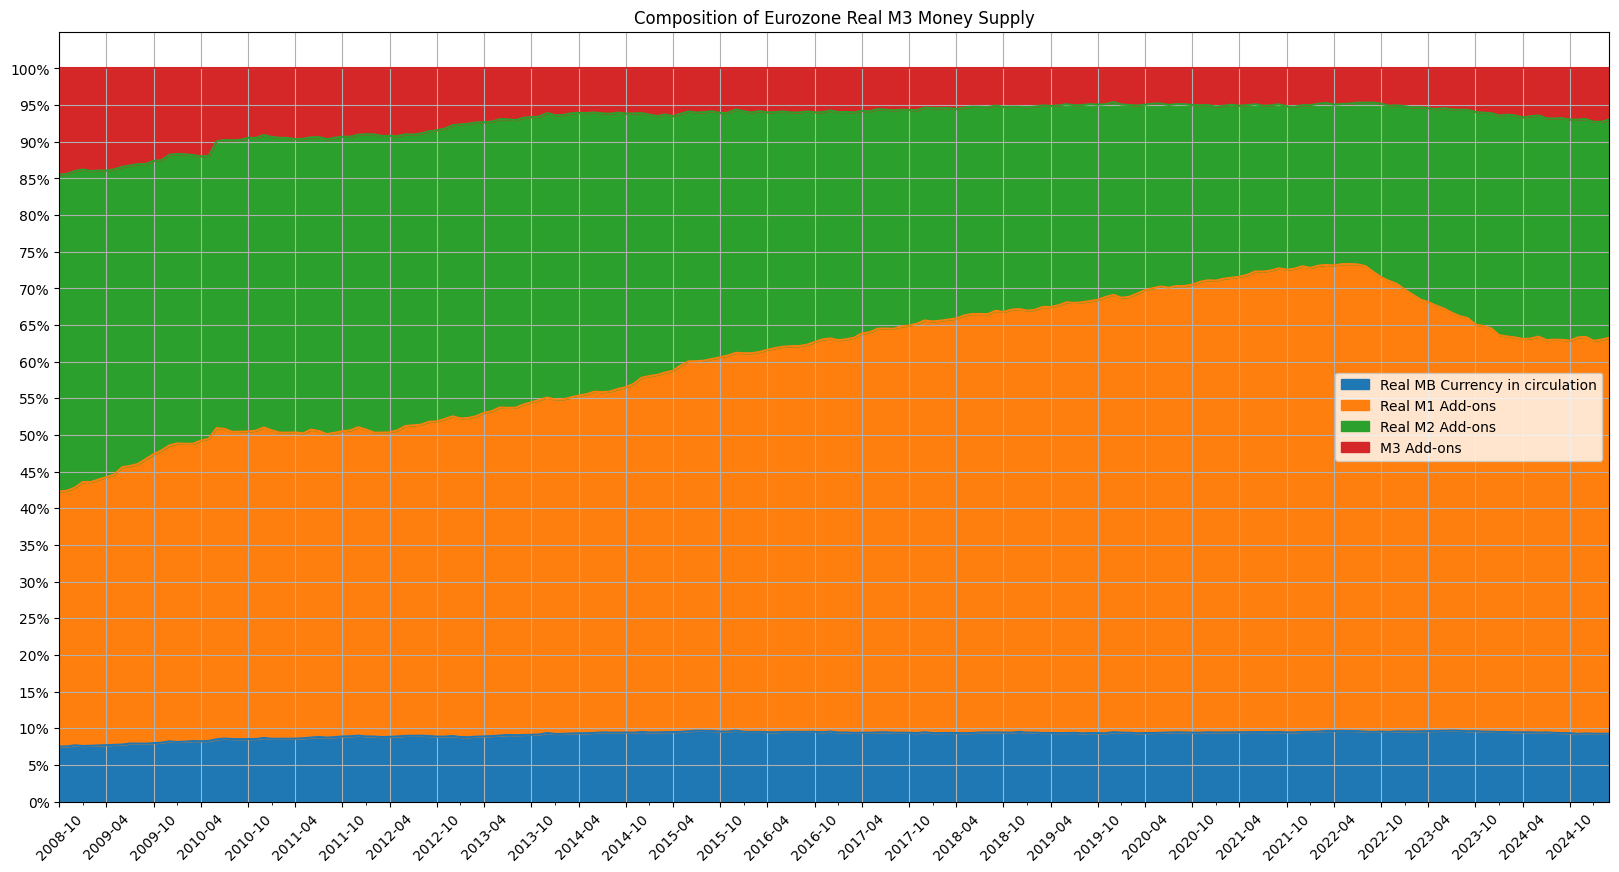

In [21]:
# Converting to percentages by dividing by total M3 Money Supply.
# Dividing by the total M3 Money Supply
m3real_df_pct = m3real_df.iloc[:,1:].divide(m3real_df.iloc[:,0], axis=0)
m3real_df_pct *= 100

ax = m3real_df_pct.plot.area(figsize=(20,10), grid=True, title=REALM3_COMPOSITION_TITLE,
                             xticks=m3real_df_pct.index[::6], xlabel='', rot=45, yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3real_df_pct.index[::6])))

## Visualizing Annual Percentage Changes in the Main Components of Eurozone's M3 Money Supply

In [22]:
m3_df_speed = (m3_df - m3_df.shift(1)).dropna()

In [23]:
# Converting to annual percentage changes (changes from the corresponding month a year ago)
m3_annual_rate = m3_df.pct_change(12).dropna()

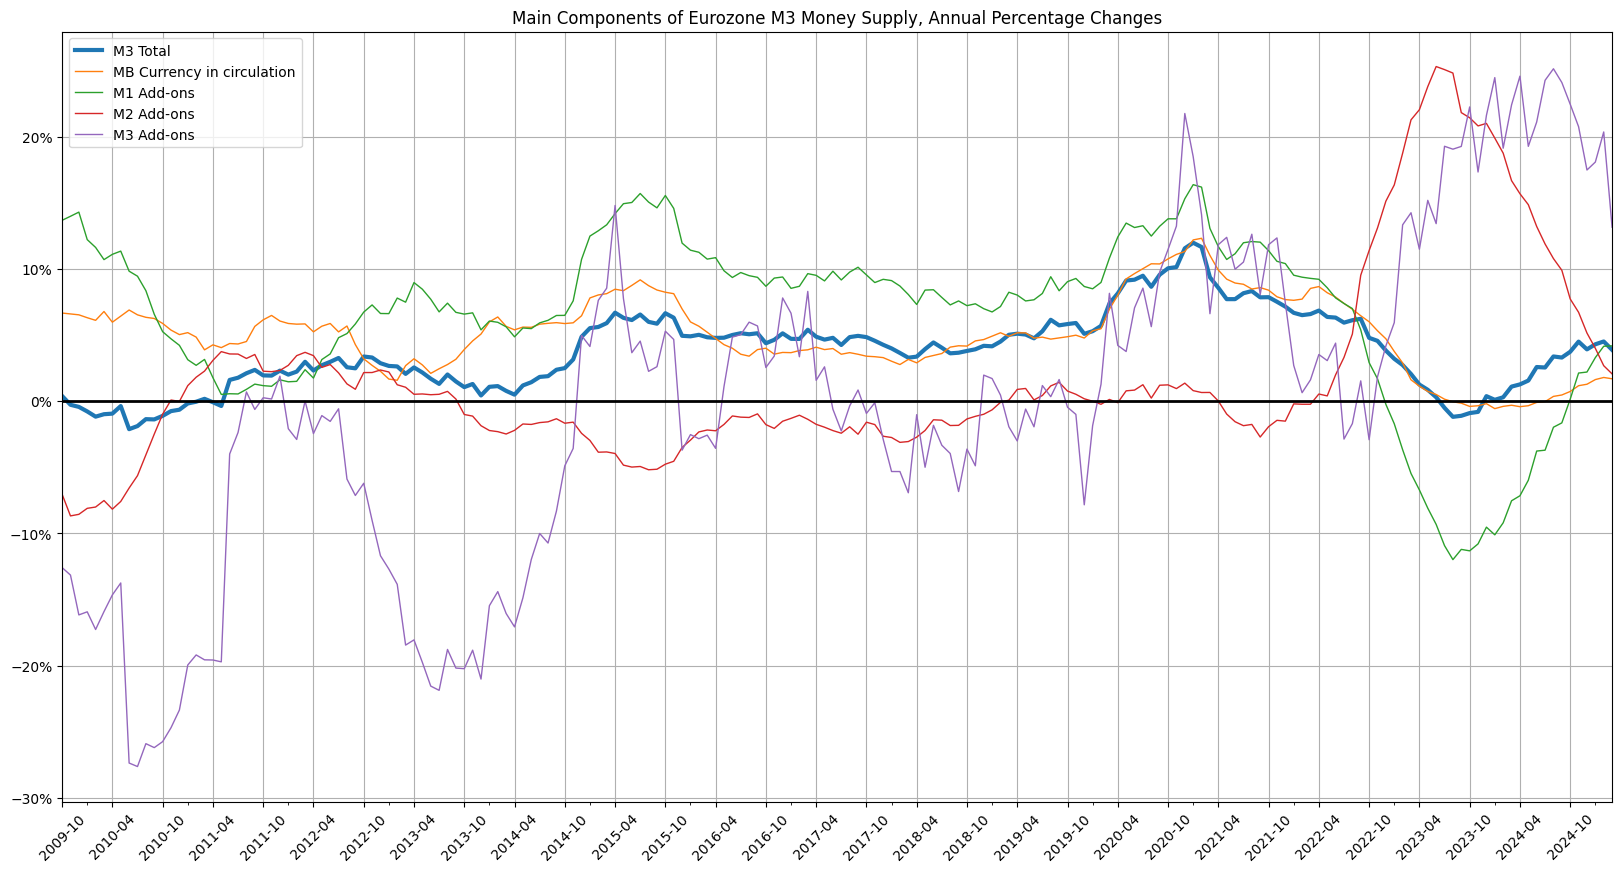

In [24]:
ax = m3_annual_rate.iloc[:,:1].plot(figsize=(20,10), grid=True, linewidth=3,
                                    title='Main Components of Eurozone M3 Money Supply, Annual Percentage Changes',
                                    xticks=m3_annual_rate.index[::6], xlabel='', rot=45)
m3_annual_rate.iloc[:,1:].plot(ax=ax, grid=True, xticks=m3_annual_rate.index[::6], xlabel='', rot=45, linewidth=1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_annual_rate.index[::6])))

In [25]:
pd.options.display.float_format = (lambda x: '{:.3%}'.format(x) if x < 100 else '{:,.0f}bn'.format(x))
m3_annual_rate.tail(12)

,M3 Total,MB Currency in circulation,M1 Add-ons,M2 Add-ons,M3 Add-ons
TIME_PERIOD,,,,,
2024-04-01,1.259%,-0.425%,-7.162%,15.679%,24.566%
2024-05-01,1.548%,-0.353%,-5.988%,14.851%,19.261%
2024-06-01,2.573%,-0.102%,-3.781%,13.201%,21.101%
2024-07-01,2.537%,-0.044%,-3.716%,11.877%,24.252%
2024-08-01,3.372%,0.352%,-1.979%,10.774%,25.125%
2024-09-01,3.290%,0.459%,-1.650%,9.890%,24.089%
2024-10-01,3.727%,0.724%,0.145%,7.721%,22.445%
2024-11-01,4.493%,1.161%,2.118%,6.712%,20.745%
2024-12-01,3.908%,1.272%,2.194%,5.144%,17.471%


## Visualizing monthly and arbitrary term changes in the components of M3

In [26]:
M3_COMPONENTS_SPEED = 'Speed of changes in Eurozone M3 Money Supply in Billions of Euros per month'
M3_COMPONENTS_CHANGES = 'Changes in Components of Eurozone M3 Money Supply in Billions of Euros'
LEFT_Y_AXIS_LABEL = 'Billions of Euros'

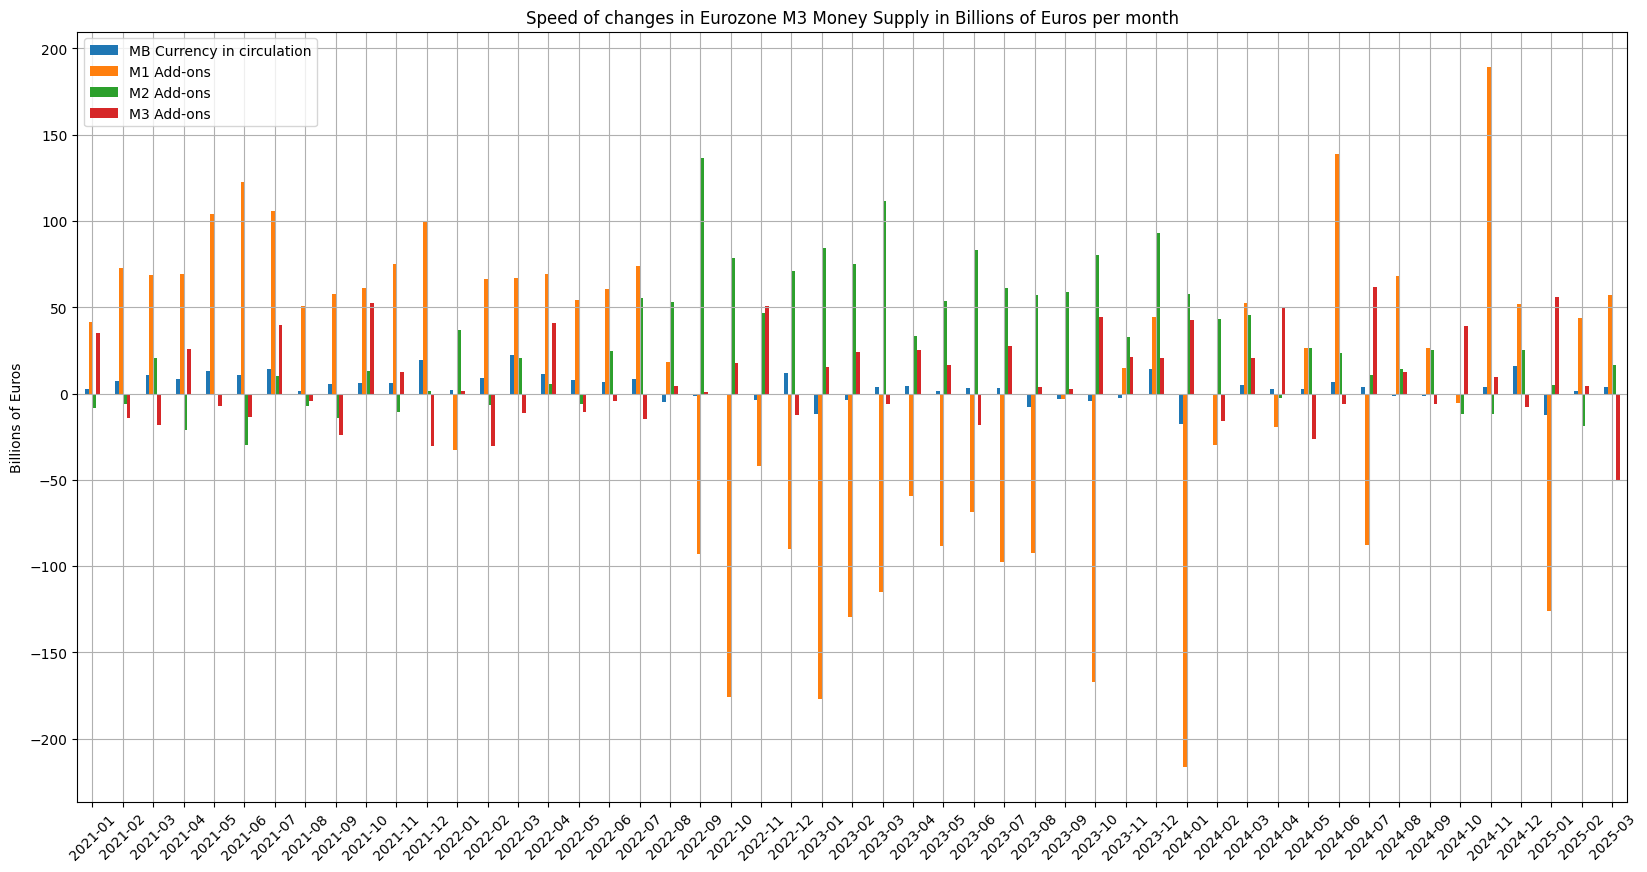

In [27]:
ax = m3_df_speed.loc['2021':, m3_df_speed.columns[1:]].plot.bar(figsize=(20,10), grid=True,
                            title=M3_COMPONENTS_SPEED, 
                            xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_df_speed.loc['2021':].index)))

In [28]:
# In months
periods = [12, 18]

In [29]:
# If you want to include currency in circulation, use iloc[-1, 1:] in the expression below
m3_df_comp_changes = pd.DataFrame([(m3_df - m3_df.shift(period)).iloc[-1, 2:] for period in periods], 
                                  index=['Over past {:d} month'.format(period) for period in periods])

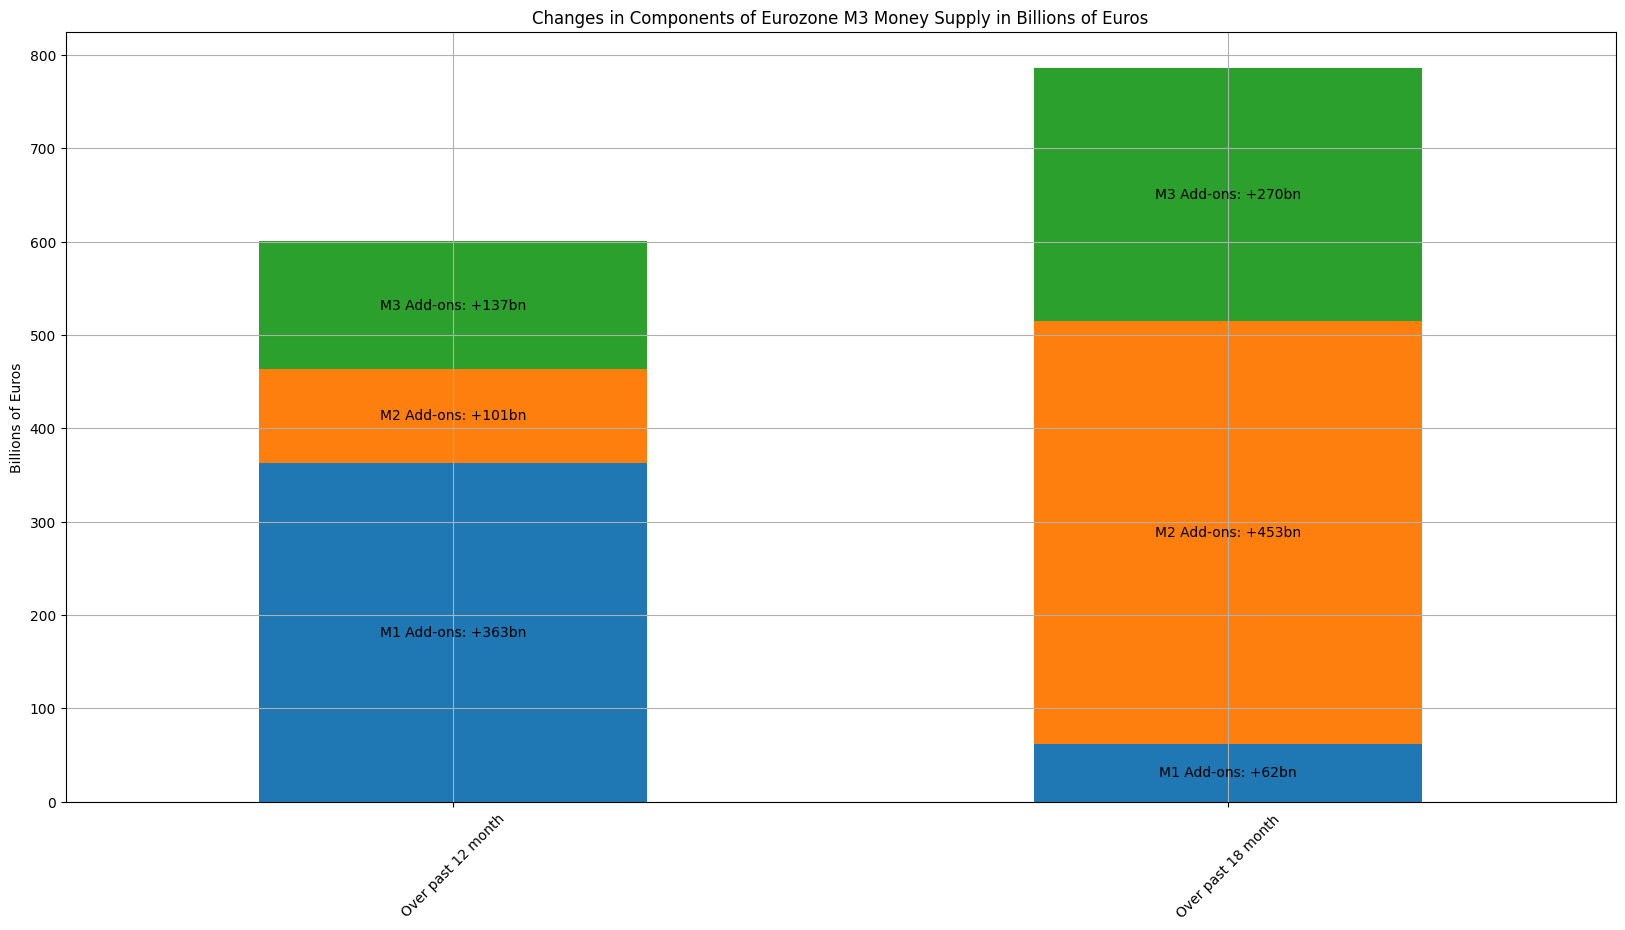

In [30]:
ax = m3_df_comp_changes.plot.bar(figsize=(20,10), grid=True, title=M3_COMPONENTS_CHANGES,
                                 stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:+.0f}bn', label_type='center')

Money supply changes in the past 3 months and in 3 months earlier

In [31]:
# In months
period = 3
offsets = [2*period, period]

In [32]:
# If you want to include currency in circulation, use iloc[-1, 1:] in the expression below
m3_df_comp_changes = pd.DataFrame([(m3_df.shift(offset-period) - m3_df.shift(offset)).iloc[-1, 2:] for offset in offsets], 
                                  index=['Over past {:d} to {:d} month'.format(offset, offset-period) for offset in offsets])

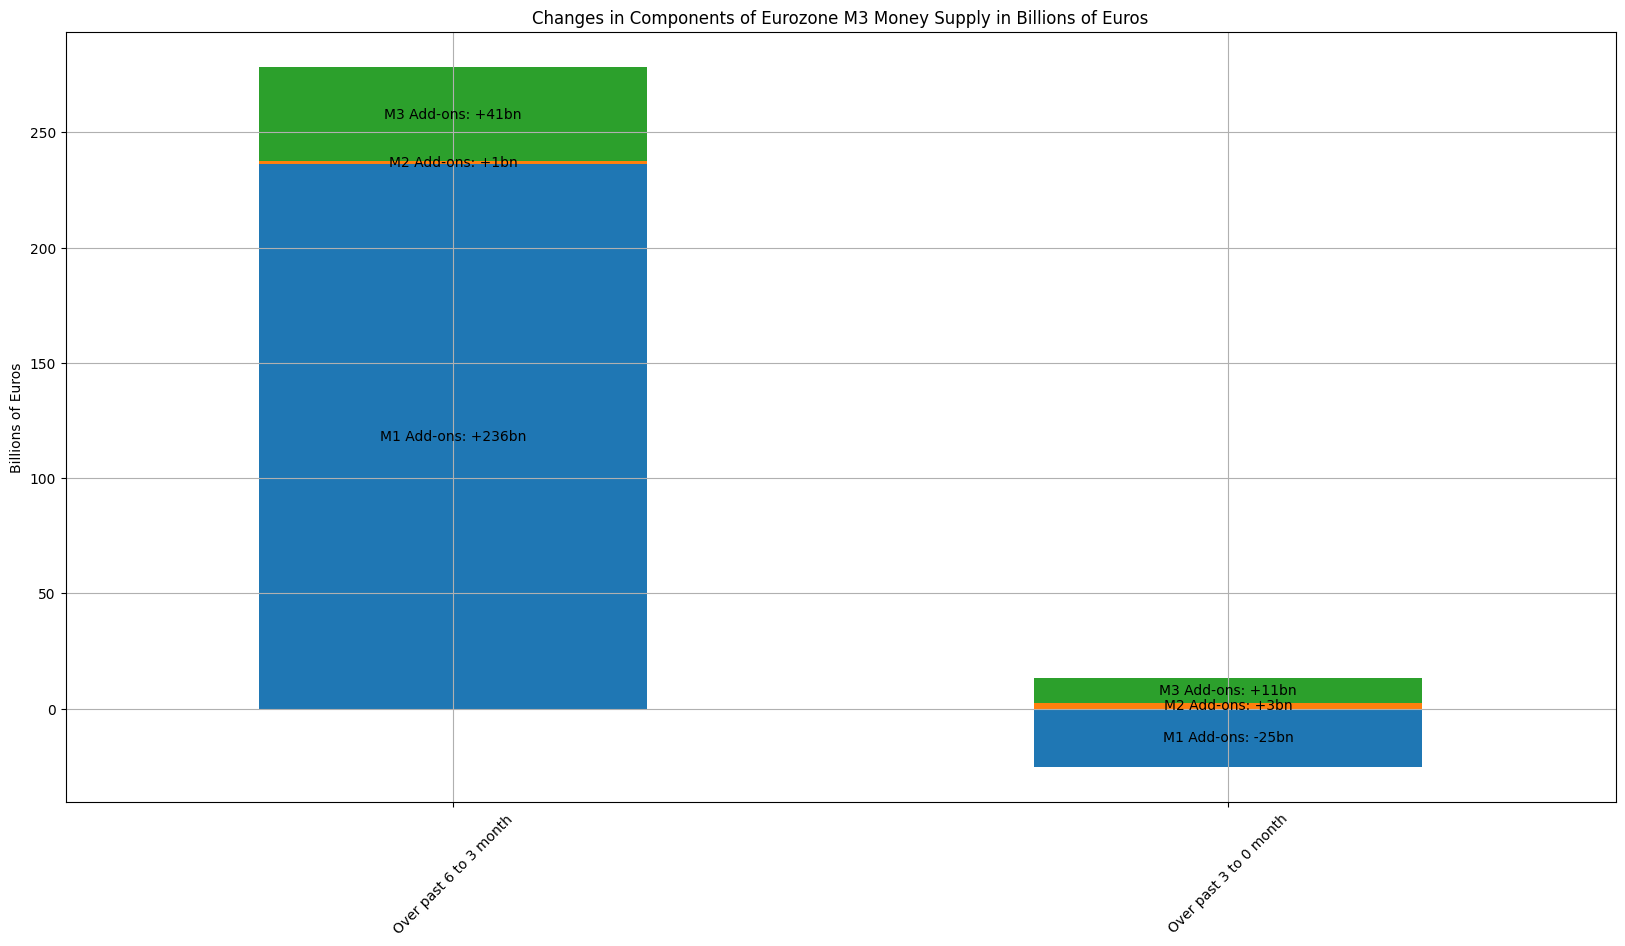

In [33]:
ax = m3_df_comp_changes.plot.bar(figsize=(20,10), grid=True, title=M3_COMPONENTS_CHANGES,
                                 stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:+.0f}bn', label_type='center')

In [34]:
m3real_annual_rate = m3real_df.pct_change(12).dropna()

In [35]:
m3real_annual_rate

,Real M3 Total,Real MB Currency in circulation,Real M1 Add-ons,Real M2 Add-ons,M3 Add-ons
TIME_PERIOD,,,,,
2009-10-01,0.515%,6.795%,13.816%,-6.925%,-12.478%
2009-11-01,-0.759%,6.076%,13.427%,-9.121%,-13.574%
2009-12-01,-1.357%,5.540%,13.234%,-9.408%,-16.942%
2010-01-01,-1.717%,5.304%,11.153%,-8.975%,-16.726%
2010-02-01,-2.007%,5.214%,10.680%,-8.785%,-17.967%
...,...,...,...,...,...
2024-11-01,2.207%,-1.052%,-0.116%,4.378%,18.104%
2024-12-01,1.439%,-1.135%,-0.235%,2.645%,14.679%
2025-01-01,1.724%,-0.878%,0.743%,1.428%,15.165%


In [36]:
m3_df_comp_changes.sum(axis=1)

Over past 6 to 3 month        278bn
Over past 3 to 0 month   -1208.790%
dtype: float64

In [37]:
pd.options.display.float_format = '{:,.0f}bn'.format
m3_df_comp_changes

,M1 Add-ons,M2 Add-ons,M3 Add-ons
Over past 6 to 3 month,236bn,1bn,41bn
Over past 3 to 0 month,-25bn,3bn,11bn
